In [1]:
import random
from numpy.random import seed
seed(3)
import numpy as np
np.random.default_rng
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import read_csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os.path import expanduser as ospath
import os
os.chdir("C:/Users/rober/project/B_Data_pre_processing/My_functions")
from C_metrics_binary import calc_binary_class_metrics
os.chdir("C:/Users/rober/project/E_models/Abstracts")

import xgboost as xgb
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

from gensim.models import Word2Vec
import gensim

## Load data set with cleaned text

In [2]:
with open(ospath('~/code_final_project/B_Data_pre_processing/Pickle_Files/Abstracts_cleaned.pickle'), 'rb') as data:
    db = pickle.load(data)

In [3]:
db.head()

,publn_nr,type,label,text,text_clean
0,4254843,Abstract,product,An electrically powered vehicle having a bank ...,electrically power vehicle bank batteries supp...
20,5680032,Abstract,product,During forward motion of an electrically-power...,forward motion electrically-powered vehicle ai...
51,5272378,Abstract,product,An apparatus for generating power by utilizing...,apparatus generate power utilize wind produce ...
68,4309620,Abstract,product,"In a preferred embodiment, the flywheel electr...",prefer embodiment flywheel electric transmissi...
118,5514923,Abstract,product,A high efficiency multi-phasic type DC motor i...,high efficiency multi-phasic type dc motor inc...


This convert name labels form string to numbers and merge into only two classes 

Process and Use claim 0, Product and Product/Process 1

In [4]:
db['label'] = db.label.replace(to_replace=['product', 'process', 'use claim', 'product and process'], value=[1, 0, 0,1])
db.groupby(by='label').count()

,publn_nr,type,text,text_clean
label,,,,
0,17,17,17,17
1,177,177,177,177


## Split the labelled data

In [5]:
random.seed(3)
y = db['label']# for stratify function
X_train, X_test, y_train , y_test = train_test_split(db['text_clean'], 
                                                    db['label'], test_size=0.4, random_state=8, stratify = y)

In [6]:
y_test.value_counts()

1    71
0     7
Name: label, dtype: int64

## Load Word2Vec model 

In [7]:
model_w2v = gensim.models.Word2Vec.load(ospath('~/code_final_project/C_Feature_extraction/model_w2v_300_uspto_epo'))

In [8]:
class MeanEmbeddingVectorizer(object):
    
    """This class builds the feature
    by averanging the word vectors
    for the words in the text"""
    
    def __init__(self, word2vec, dim):
        self.word2vec = word2vec
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
# reference http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [9]:
w2v = {w: vec for w, vec in zip(model_w2v.wv.index2word, model_w2v.wv.syn0)}

In [10]:
w2v_vector = MeanEmbeddingVectorizer(w2v,300)

## Fit Word2Vec vectorizer 

In [11]:
X_train_w2v = w2v_vector.fit(X_train,y_train)
X_train_w2v = w2v_vector.transform(X_train)
X_test_w2v = w2v_vector.transform(X_test)

## Balance the classes with SMOTE 

In [12]:
balance = SMOTE()
X_train_w2v_bal, y_train_w2v_bal = balance.fit_resample(X_train_w2v, y_train)

I will run first an untuned XGBoost model uisng Word2Vec by from the spot-check phase resulted that this ensemble model with this word representation gives good results - see results in ***project\D_Spot-Check\Abstracts*.

## Run XGboost algorithm with Word2Vec

In [13]:
random.seed(3)
xb = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)
xb.fit(X_train_w2v_bal, y_train_w2v_bal)
pred_test = xb.predict(X_test_w2v)


print("Accuracy on test data: \n",metrics.accuracy_score(y_test, pred_test))
print("Classification report: \n",metrics.classification_report(y_test, pred_test))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, pred_test)))

Accuracy on test data: 
 0.8974358974358975
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      0.99      0.95        71

    accuracy                           0.90        78
   macro avg       0.45      0.49      0.47        78
weighted avg       0.83      0.90      0.86        78

Confusion Matrix test: 
[[ 0  7]
 [ 1 70]]


### Not very good results since it has not classified any abstracts from the minority class. I will try with a different vectorizer.

## Fit TF-IDF vectorizer 

In [14]:
tfidf = TfidfVectorizer(ngram_range = (1,2) , encoding='utf-8',sublinear_tf=True)

X_train_tf = tfidf.fit_transform(X_train).toarray()
X_test_tf = tfidf.transform(X_test).toarray()

## Balance the classe with SMOTE and TF-IDF as word representation

In [15]:
oversample = SMOTE()
X_train_tf_bal, y_train_tf_bal = oversample.fit_resample(X_train_tf, y_train)

## Rerun XGBoost with TF-IDF before tuning it

In [16]:
random.seed(3)
xbg_tf = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)
xbg_tf.fit(X_train_tf_bal, y_train_tf_bal)
xbg_tf_pred = xbg_tf.predict(X_test_tf)

print("Accuracy on the test data: ")
print(metrics.accuracy_score(y_test, xbg_tf_pred))
print("Classification report")
print(metrics.classification_report(y_test, xbg_tf_pred))
print('Confusion Matrix : ')
print(metrics.confusion_matrix(y_test, xbg_tf_pred))

Accuracy on the test data: 
0.9102564102564102
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        71

    accuracy                           0.91        78
   macro avg       0.46      0.50      0.48        78
weighted avg       0.83      0.91      0.87        78

Confusion Matrix : 
[[ 0  7]
 [ 0 71]]


### It improved slightly a bit because it was able to classify correctly all the observations from the majority class but zero again for the other class.

## Tune TF-IDF with GRid Search CV

In [17]:
random.seed(3)
pipeline_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('clf', OneVsRestClassifier(xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1))),
])
param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]

}

grid_search_tfidf_xgb = GridSearchCV(pipeline_grid, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search_tfidf_xgb.fit(X_train, y_train)

print("Best parameters for the TF-IDF: {}".format(grid_search_tfidf_xgb.best_estimator_.steps))

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Best parameters for the TF-IDF: [('tfidf', TfidfVectorizer(lowercase=False, max_features=300)), ('clf', OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
               

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished


## Fit TF-IDF vectorizer with the new parameters

In [18]:
print(grid_search_tfidf_xgb.best_params_)

{'tfidf__max_features': 300, 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False}


In [19]:
tfidf_tune = grid_search_tfidf_xgb.best_estimator_[0]

X_train_tf_tune = tfidf_tune.fit_transform(X_train).toarray()
X_test_tf_tune = tfidf_tune.transform(X_test).toarray()

## Balance again the classes with SMOTE with net TF-IDF vectorizer 

In [20]:
oversample = SMOTE()
X_train_tf_tune_bal, y_train_tf_tune_bal = oversample.fit_resample(X_train_tf_tune, y_train)

In [21]:
seed(3)
xbg_tf_tune = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)
xbg_tf_tune.fit(X_train_tf_tune_bal, y_train_tf_tune_bal)
xbg_tf_tune_pred = xbg_tf_tune.predict(X_test_tf_tune)

print("Accuracy on the test data: ")
print(metrics.accuracy_score(y_test, xbg_tf_tune_pred))
print("Classification report")
print(metrics.classification_report(y_test, xbg_tf_tune_pred))
print('Confusion Matrix : ')
print(metrics.confusion_matrix(y_test, xbg_tf_tune_pred))

Accuracy on the test data: 
0.9230769230769231
Classification report
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.92      1.00      0.96        71

    accuracy                           0.92        78
   macro avg       0.96      0.57      0.60        78
weighted avg       0.93      0.92      0.90        78

Confusion Matrix : 
[[ 1  6]
 [ 0 71]]


### There is an improvement since the model was able to classify also one observation from the minority class.

Now, I tune also the parameters of the learning algorithm. 

## Tune Hyperparametrs XGBoost algorithm 

In [22]:
param_grid = {
    'max_depth': [2,4,6,8,10],
    'n_estimators': [60, 10,120,160,200, 240],
    'learning_rate': [0.1, 0.01, 0.05, 0.009]
}

In [23]:
random.seed(3)
xb = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=-1)


random_search = RandomizedSearchCV(estimator=xb,
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1)

random_search.fit(X_train_tf_tune, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   13.7s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                            

In [24]:
print(random_search.best_params_)

{'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.05}


In [25]:
random.seed(3)
xb_both_tune = random_search.best_estimator_
xb_both_tune.fit(X_train_tf_tune_bal, y_train_tf_tune_bal)
xb_both_tune_train = xb_both_tune.predict(X_train_tf_tune)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_train, xb_both_tune_train))
print("Classification report: \n",metrics.classification_report(y_train, xb_both_tune_train))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_train, xb_both_tune_train)))

Accuracy on validation data: 
 0.9741379310344828
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.99      0.98      0.99       106

    accuracy                           0.97       116
   macro avg       0.90      0.94      0.92       116
weighted avg       0.98      0.97      0.97       116

Confusion Matrix validation: 
[[  9   1]
 [  2 104]]


In [26]:
xb_both_tune_pred = xb_both_tune.predict(X_test_tf_tune)


print("Accuracy on validation data: \n",metrics.accuracy_score(y_test, xb_both_tune_pred))
print("Classification report: \n",metrics.classification_report(y_test, xb_both_tune_pred))
print('Confusion Matrix validation: \n' + str(metrics.confusion_matrix(y_test, xb_both_tune_pred)))

Accuracy on validation data: 
 0.8461538461538461
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.90      0.93      0.92        71

    accuracy                           0.85        78
   macro avg       0.45      0.46      0.46        78
weighted avg       0.82      0.85      0.83        78

Confusion Matrix validation: 
[[ 0  7]
 [ 5 66]]


The results are a bit worse than since now it misclassified extra observations from the majority class.

Many models have performed the same in the spot-check phase and from them I chose the Logistic Regression to be run here. 

## Run a Logistic Regression with Word2Vec word representation

In [27]:
random.seed(3)
logi_w2v = LogisticRegression( random_state=0, n_jobs=-1)
logi_w2v.fit(X_train_w2v_bal, y_train_w2v_bal )
logi_w2v_pred = logi_w2v.predict(X_test_w2v)


print("Accuracy on the test data: ")
print(metrics.accuracy_score(y_test, logi_w2v_pred))
print("Classification report")
print(metrics.classification_report(y_test, logi_w2v_pred))
print('Confusion Matrix : ')
print(metrics.confusion_matrix(y_test, logi_w2v_pred))

Accuracy on the test data: 
0.6153846153846154
Classification report
              precision    recall  f1-score   support

           0       0.13      0.57      0.21         7
           1       0.94      0.62      0.75        71

    accuracy                           0.62        78
   macro avg       0.53      0.60      0.48        78
weighted avg       0.86      0.62      0.70        78

Confusion Matrix : 
[[ 4  3]
 [27 44]]


Very disappointing results with Word2Vec. Now, I wil try with TF-IDF word representation.

## Run a Logistic Regression with a TF-IDF not tuned

In [28]:
random.seed(3)
logi = LogisticRegression( random_state=0, n_jobs=-1)
logi.fit(X_train_tf_bal, y_train_tf_bal )
logi_pred = logi.predict(X_test_tf)


print("Accuracy on the test data: ")
print(metrics.accuracy_score(y_test, logi_pred))
print("Classification report")
print(metrics.classification_report(y_test, logi_pred))
print('Confusion Matrix : ')
print(metrics.confusion_matrix(y_test, logi_pred))

Accuracy on the test data: 
0.8846153846153846
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      0.97      0.94        71

    accuracy                           0.88        78
   macro avg       0.45      0.49      0.47        78
weighted avg       0.83      0.88      0.85        78

Confusion Matrix : 
[[ 0  7]
 [ 2 69]]


## Tune the TF-IDF vectorizer for the Logistic

In [29]:
random.seed(3)
pipeline_grid = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('clf', OneVsRestClassifier(LogisticRegression( random_state=0))),
])
param_grid = {
    'tfidf__norm' :('l1', 'l2'),
    'tfidf__max_features' : (300, 350, 400, 450,500),
    'tfidf__sublinear_tf' : [True, False]
}

grid_search_tfidf_logi = GridSearchCV(pipeline_grid, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search_tfidf_logi.fit(X_train, y_train)

print("Best parameters for the TF-IDF: {}".format(grid_search_tfidf_logi.best_estimator_.steps))

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Best parameters for the TF-IDF: [('tfidf', TfidfVectorizer(lowercase=False, max_features=300, norm='l1', sublinear_tf=True)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(random_state=0)))]


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


## Fit the new TF-IDF vect

In [30]:
tfidf_tune_logi = grid_search_tfidf_logi.best_estimator_[0]
X_train_tf_tune = tfidf_tune_logi.fit_transform(X_train).toarray()
X_test_tf_tune = tfidf_tune_logi.transform(X_test).toarray()

## Balance the classes with SMOTE with the new TF-IDF

In [31]:
oversample = SMOTE()
X_train_tf_tune_bal, y_train_tf_tune_bal = oversample.fit_resample(X_train_tf_tune, y_train)

In [32]:
random.seed(3)
logi_tf_tune = LogisticRegression( random_state=0, n_jobs=-1)
logi_tf_tune.fit(X_train_tf_tune_bal, y_train_tf_tune_bal)
pred_tf_tune = logi_tf_tune.predict(X_test_tf_tune)


print("Accuracy on the test data: ")
print(metrics.accuracy_score(y_test, pred_tf_tune))
print("Classification report")
print(metrics.classification_report(y_test, pred_tf_tune))
print('Confusion Matrix : ')
print(metrics.confusion_matrix(y_test, pred_tf_tune))

Accuracy on the test data: 
0.8333333333333334
Classification report
              precision    recall  f1-score   support

           0       0.12      0.14      0.13         7
           1       0.91      0.90      0.91        71

    accuracy                           0.83        78
   macro avg       0.52      0.52      0.52        78
weighted avg       0.84      0.83      0.84        78

Confusion Matrix : 
[[ 1  6]
 [ 7 64]]


The results are not very good.
Therefore, he best model is than the XGBoost with its default parameters. I save this model and use it for the pseudo labelling experiments. 

## Save the best model XGBoost - with only TF-IDF tuned
I use pickle to save the model and train and test datasets that I need for the extra experiments. 

In [33]:
#save the model
with open('Pickle_Files/xgb_model_abstracts.pickle', 'wb') as model:
    pickle.dump(xbg_tf_tune, model)
    
#save X train data - features 
with open('Pickle_Files/X_train_abstracts.pickle', 'wb') as data:
    pickle.dump(X_train, data)
    
#save y train data - labels
with open('Pickle_Files/y_train_abstracts.pickle', 'wb') as data:
    pickle.dump(y_train, data)
    
#save X test data - features
with open('Pickle_Files/X_test_abstracts.pickle', 'wb') as data:
    pickle.dump(X_test, data)
    
#save y test data - labels
with open('Pickle_Files/y_test_abstracts.pickle', 'wb') as data:
    pickle.dump(y_test, data)
    
#save tf-df fitted vectorizer to use for the pseudo labelling experiments
with open('Pickle_Files/tfidf_tune_abstracts.pickle', 'wb') as model:
    pickle.dump(tfidf_tune, model)


**Print the best results.**

In [34]:
sc = calc_binary_class_metrics(y_test, xbg_tf_tune_pred, 'XB TF tuned', 'Test')
sc

,Model,Data,Precision,Recall,Specificity,F1-score,Accuracy,Bal Accuracy,AUC
0,XB TF tuned,Test,0.922078,1.0,0.142857,0.959459,0.923077,0.571429,0.571429


As expected, it is very good to classify the majority class since it did classify all the observation within that class but it  did perform very bad with the minority class by predicting only one observations of the latter class. 

In [35]:
print('Confusion Matrix : ')
print(metrics.confusion_matrix(y_test, xbg_tf_tune_pred))

Confusion Matrix : 
[[ 1  6]
 [ 0 71]]


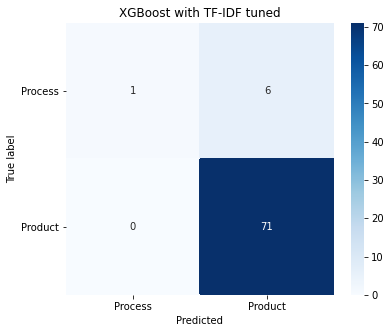

In [39]:
#https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/06.%20MT%20-%20Random%20Forest.ipynb
aux_db = db[['label']].drop_duplicates().sort_values('label')
conf_matrix = metrics.confusion_matrix(y_test, xbg_tf_tune_pred)
plt.figure(figsize=(6,5))
aux_db['label'] = aux_db.label.replace(to_replace=[1, 0], value=['Product', 'Process'])
conf = sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_db['label'].values, 
            yticklabels=aux_db['label'].values,
            cmap="Blues")
conf.set_yticklabels(conf.get_yticklabels(), rotation=360)
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('XGBoost with TF-IDF tuned')
plt.show()

In [37]:
print(grid_search_tfidf_xgb.best_params_)

{'tfidf__max_features': 300, 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False}
